<a href="https://colab.research.google.com/github/Sagar-modelling/OpenCV-East.ipynb/blob/main/OpenCV_East.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2

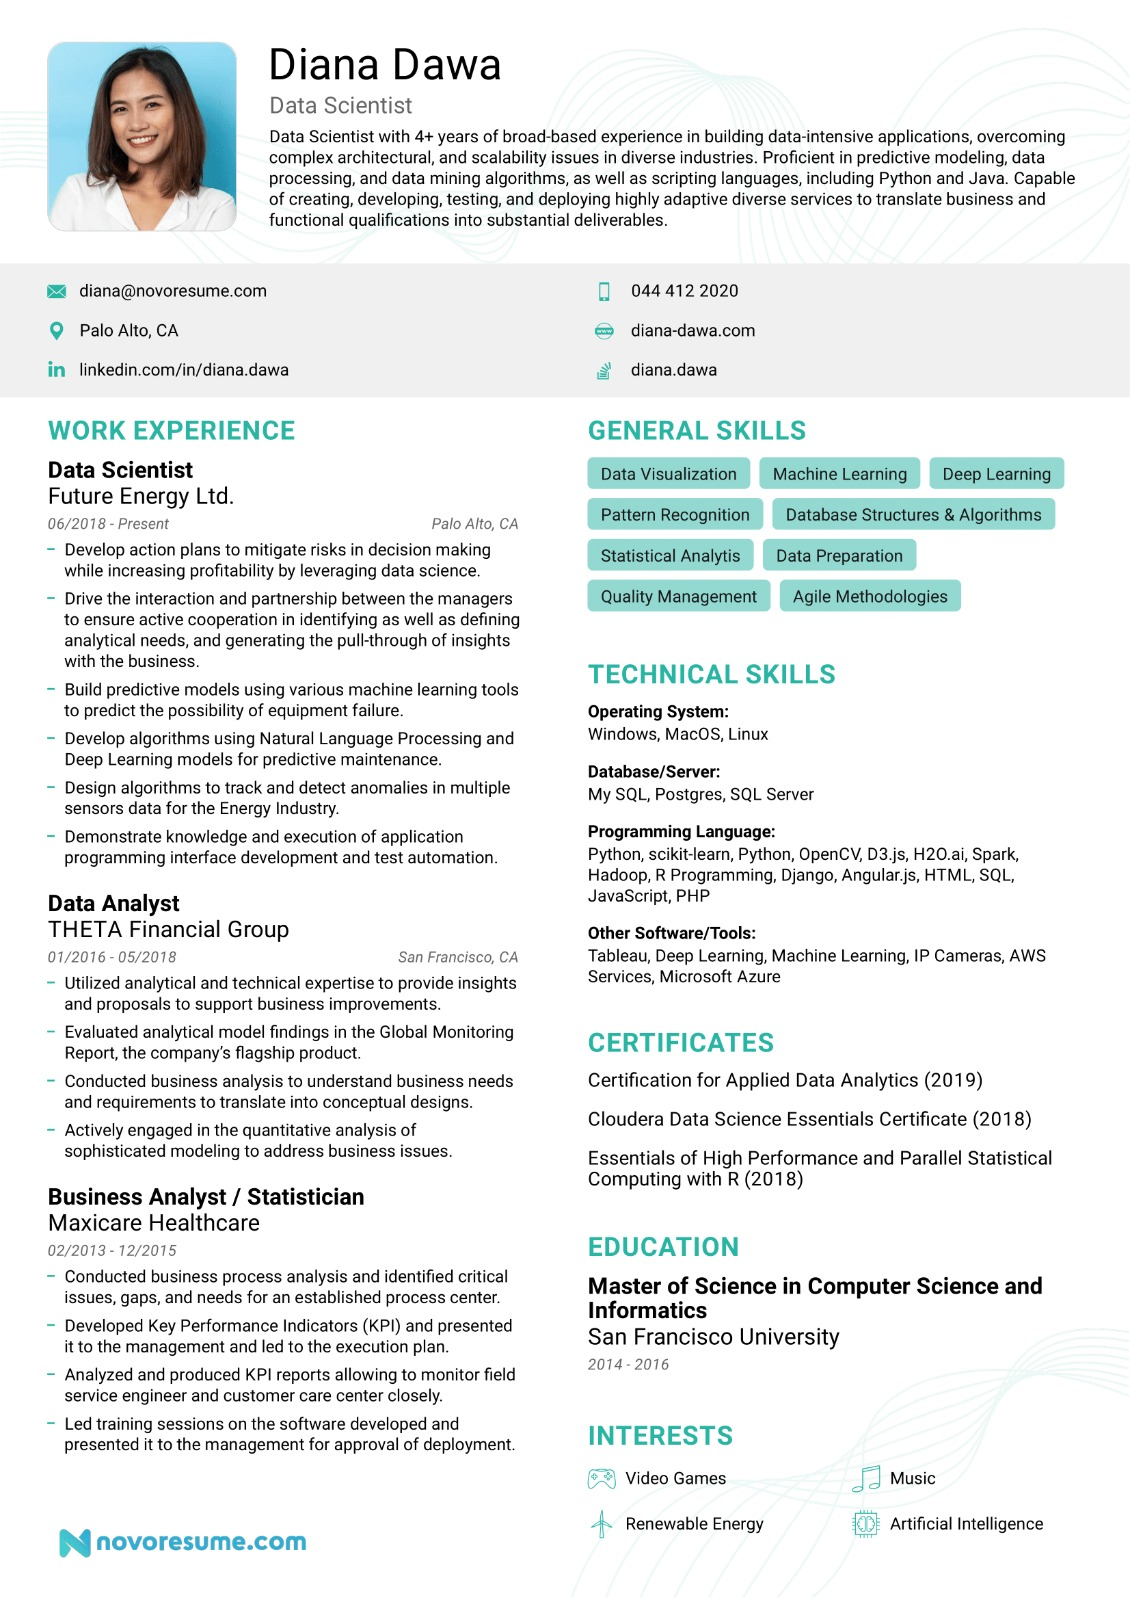

In [46]:
img = cv2.imread('/content/sample_resume.jpg',cv2.IMREAD_UNCHANGED)
cv2_imshow(img)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [47]:
!tar -xzvf "/content/gdrive/MyDrive/frozen_east_text_detection.tar.gz"

frozen_east_text_detection.pb


In [48]:
# Download the EAST model and Load it
model = cv2.dnn.readNet('/content/frozen_east_text_detection.pb')
model

<dnn_Net 0x7ff08e2d6f90>

In [49]:
# ## Prepare the image
# use multiple of 32 to set the new img shape
height, width, _ = img.shape
new_height = (height//32)*32
new_width = (width//32)*32
print(new_height, new_width)

1600 1120


In [50]:
# get the ratio change in width and height
h_ratio = height/new_height
w_ratio = width/new_width
print(h_ratio, w_ratio)

1.0 1.0089285714285714


In [51]:
blob = cv2.dnn.blobFromImage(img, 1, (new_width, new_height),(123.68, 116.78, 103.94), True, False)

In [52]:
# ## Pass the image to network and extract score and geometry map
model.setInput(blob)

In [53]:
model.getUnconnectedOutLayersNames() #get names of output layers that calculate geometry maps(concat_3) and scores(Conv_7) respectively.

['feature_fusion/concat_3', 'feature_fusion/Conv_7/Sigmoid']

In [54]:
(geometry, scores) = model.forward(model.getUnconnectedOutLayersNames())

In [55]:
(geometry).shape

(1, 5, 400, 280)

In [56]:
(scores).shape

(1, 1, 400, 280)

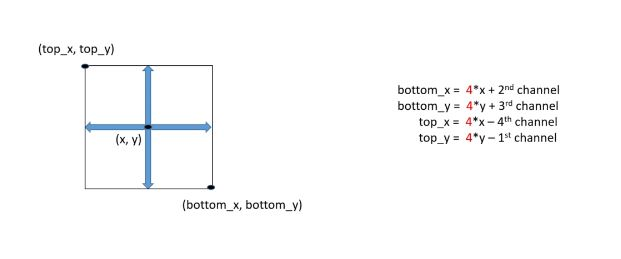

In [57]:
img_src = cv2.imread('/content/Capture.JPG',cv2.IMREAD_UNCHANGED)
cv2_imshow(img_src)

In [58]:
# ## Post-Processing
rectangles = [] #list 1
confidence_score = [] #list 2
for i in range(geometry.shape[2]): #iterate each pixel row by row to construct counding boxes. shape[2] pixel value = 96
    for j in range(0, geometry.shape[3]):  #shape[3] pixel value =160
        
        if scores[0][0][i][j] < 0.1:  #if score of pixel is less than threshold then we don't consider the pixel and we continue
            continue
            #otherwise obtain bounding box coordinates as follows
        bottom_x = int(j*4 + geometry[0][1][i][j])
        bottom_y = int(i*4 + geometry[0][2][i][j])
        

        top_x = int(j*4 - geometry[0][3][i][j])
        top_y = int(i*4 - geometry[0][0][i][j])
        
        rectangles.append((top_x, top_y, bottom_x, bottom_y))
        confidence_score.append(float(scores[0][0][i][j]))

In [59]:
from imutils.object_detection import non_max_suppression

In [60]:
# use Non-max suppression to get the required rectangles
import numpy as np
fin_boxes = non_max_suppression(np.array(rectangles), probs=confidence_score, overlapThresh=0.5) #this NMS function only works for non roated text boxes.
fin_boxes

array([[ 786,  587,  822,  604],
       [ 835,  947,  900,  963],
       [ 231, 1183,  363, 1206],
       ...,
       [ 196,  779,  222,  795],
       [  61,  610,   91,  627],
       [ 840,  191,  866,  204]])

In [61]:
#display text boxes and converting to original shape
img_copy = img.copy()
for (x1, y1, x2, y2) in fin_boxes:

    x1 = int(x1 * w_ratio)
    y1 = int(y1 * h_ratio)
    x2 = int(x2 * w_ratio)
    y2 = int(y2 * h_ratio)

    cv2.rectangle(img_copy, (x1, y1), (x2, y2), (0,255,0) , 2) #to draw rectangles on the image

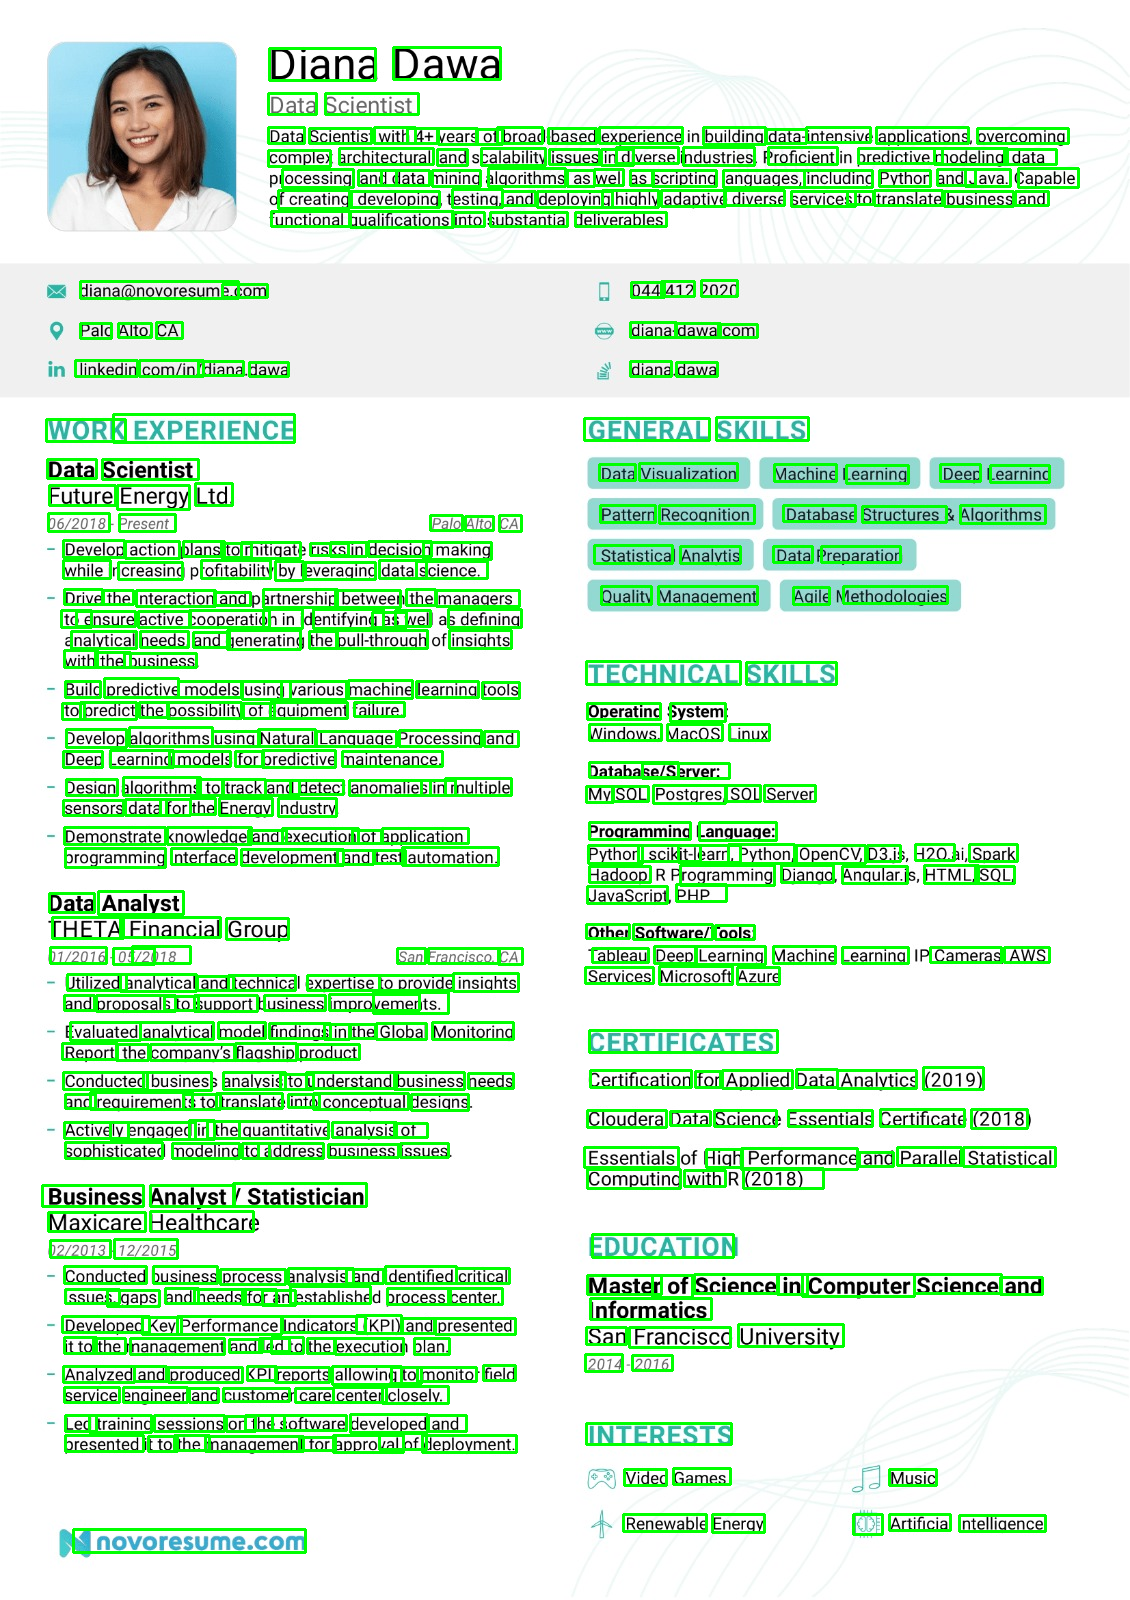

In [62]:
cv2_imshow(img_copy)